In [1]:
import os,sys,time
from loguru import logger 

import scimap as sm

import numpy as np
import pandas as pd
import shapely
import geopandas as gpd
import anndata as ad

import pyarrow
import ast

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

#custom functions
sys.path.append(os.path.abspath('/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/src/'))
import opendvp.anndata_utils
import opendvp.filtering
import importlib

for package in [np,pd,gpd,ad,sm]:
    print(f"{package.__name__} {package.__version__}")

Running SCIMAP  2.2.11
numpy 1.26.4
pandas 2.2.3
geopandas 1.0.1
anndata 0.10.9
scimap 2.2.11


## Step 1: Merge phenotyped adatas

In [2]:
adata_991 = ad.read_h5ad("../data/perSample/991/adata_checkpoints/7_adata_pheno/20250302_1823_7_adata_pheno_adata.h5ad")
adata_992 = ad.read_h5ad("../data/perSample/992/adata_checkpoints/7_adata_pheno/20250303_1112_7_adata_pheno_adata.h5ad")

In [3]:
adata_concat = ad.concat([adata_991,adata_992])

/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/anndata/_core/anndata.py:1754: UserWarning:

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.

/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/anndata/_core/anndata.py:1754: UserWarning:

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.



In [15]:
adata_concat.obs['imageid'].value_counts()

imageid
992    1005051
991     610182
Name: count, dtype: int64

In [27]:
adata_concat.obs['cell_id'] = adata_concat.obs['imageid'].astype('str') + "_" + adata_concat.obs['CellID'].astype('str')

In [29]:
opendvp.anndata_utils.save_adata_checkpoint(adata_concat, path_to_dir="../data/perSample/991_992/", checkpoint_name="0_concat")

2025-03-03 13:36:30.990 | INFO     | opendvp.anndata_utils:save_adata_checkpoint:73 - Writing h5ad
2025-03-03 13:36:33.154 | SUCCESS  | opendvp.anndata_utils:save_adata_checkpoint:75 - Wrote h5ad file
2025-03-03 13:36:33.154 | INFO     | opendvp.anndata_utils:save_adata_checkpoint:82 - Writing parquet
2025-03-03 13:36:33.953 | SUCCESS  | opendvp.anndata_utils:save_adata_checkpoint:84 - Wrote parquet file


## Compare phenotypes

In [45]:
x_axis='imageid'
y_axis='phenotype'

data = pd.DataFrame(adata_concat.obs)[[x_axis, y_axis]].astype(str)

In [46]:
data

,imageid,phenotype
0,991,Cancer_cells
1,991,Cancer_cells
2,991,Cancer_cells
3,991,CD4_Tcells
4,991,Cancer_cells
...,...,...
1134342,992,Unknown
1134343,992,Cancer_cells
1134344,992,Cancer_cells
1134345,992,Cancer_cells


In [47]:
total = data.groupby([x_axis, y_axis]).size().unstack().fillna(0).sum(axis=1)
rg = pd.DataFrame(
    data.groupby([x_axis, y_axis])
    .size()
    .unstack()
    .fillna(0)
    .div(total, axis=0)
    .stack()
)

In [48]:
total

imageid
991     610182
992    1005051
dtype: int64

In [49]:
rg

0
imageid phenotype               
991     B_cells         0.005864
        CD4_Tcells      0.179184
        CD8_Tcells      0.014465
        COL1A1_cells    0.073952
        Cancer_cells    0.354643
        Macrophages     0.001509
        Unknown         0.357382
        Vimentin_cells  0.013001
992     B_cells         0.000386
        CD4_Tcells      0.050116
        CD8_Tcells      0.002024
        COL1A1_cells    0.074786
        Cancer_cells    0.691446
        Macrophages     0.014147
        Unknown         0.134296
        Vimentin_cells  0.032800

In [67]:
rg.columns = ['count']
rg

count
imageid phenotype               
991     B_cells         0.005864
        CD4_Tcells      0.179184
        CD8_Tcells      0.014465
        COL1A1_cells    0.073952
        Cancer_cells    0.354643
        Macrophages     0.001509
        Unknown         0.357382
        Vimentin_cells  0.013001
992     B_cells         0.000386
        CD4_Tcells      0.050116
        CD8_Tcells      0.002024
        COL1A1_cells    0.074786
        Cancer_cells    0.691446
        Macrophages     0.014147
        Unknown         0.134296
        Vimentin_cells  0.032800

In [68]:
# Add the index as columns in the data frame
rg.reset_index(inplace=True)
rg


,imageid,phenotype,count
0,991,B_cells,0.005864
1,991,CD4_Tcells,0.179184
2,991,CD8_Tcells,0.014465
3,991,COL1A1_cells,0.073952
4,991,Cancer_cells,0.354643
5,991,Macrophages,0.001509
6,991,Unknown,0.357382
7,991,Vimentin_cells,0.013001
8,992,B_cells,0.000386
9,992,CD4_Tcells,0.050116


In [69]:
pivot_df = rg.pivot(index=x_axis, columns=y_axis, values='count')
pivot_df

phenotype,B_cells,CD4_Tcells,CD8_Tcells,COL1A1_cells,Cancer_cells,Macrophages,Unknown,Vimentin_cells
imageid,,,,,,,,
991,0.005864,0.179184,0.014465,0.073952,0.354643,0.001509,0.357382,0.013001
992,0.000386,0.050116,0.002024,0.074786,0.691446,0.014147,0.134296,0.032800


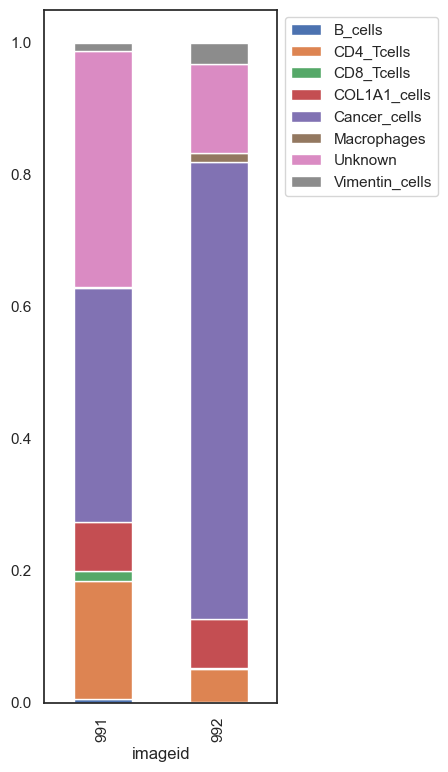

In [79]:
fig,ax = plt.subplots()
fig.set_size_inches(3, 9)
pivot_df.plot.bar(stacked=True, ax=ax)

plt.legend(bbox_to_anchor=(1,1))

plt.show()

# Heatmap for measured intensities 

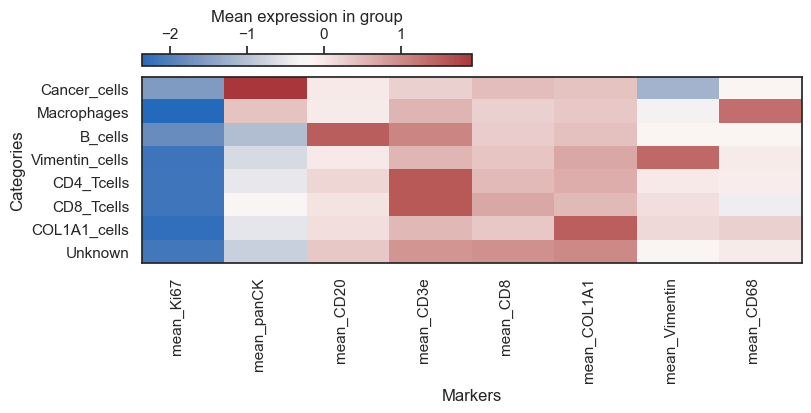

In [86]:
sm.pl.heatmap(adata_concat, groupBy="phenotype", figsize=(8,4), standardScale="column")

In [87]:
adata_concat

AnnData object with n_obs × n_vars = 1615233 × 8
    obs: 'CellID', 'Y_centroid', 'X_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Orientation', 'Extent', 'Solidity', 'artefact', 'Area_filter_nottoobig', 'Area_filter_nottoolow', 'Area_filter', 'DAPI_ratio', 'DAPI_ratio_pass_nottoolow', 'DAPI_ratio_pass_nottoohigh', 'DAPI_ratio_pass', 'filtering', 'imageid', 'phenotype', 'cell_id'
    layers: 'log'

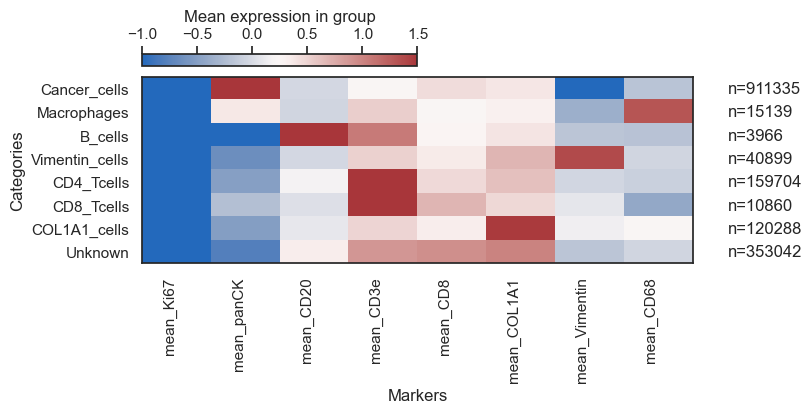

In [115]:
sm.pl.heatmap(
    adata=adata_concat,
    groupBy="phenotype",
    # layer="log",
    # subsetGroups=["B_cells","Vimentin_cells", "CD4_Tcells", "CD8_Tcells", "COL1A1_cells", "Cancer_cells", "Macrophages"],
    clusterRows=True,
    clusterColumns=True,
    standardScale="column",
    showPrevalence=True,
    figsize=(8,4),
    vmin=-1, vmax=1.5 
    )

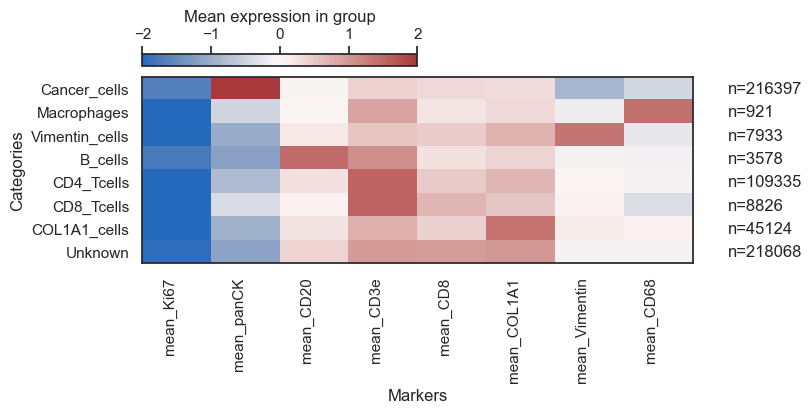

In [116]:
sm.pl.heatmap(
    adata=adata_991,
    groupBy="phenotype",
    # layer="log",
    # subsetGroups=["B_cells","Vimentin_cells", "CD4_Tcells", "CD8_Tcells", "COL1A1_cells", "Cancer_cells", "Macrophages"],
    standardScale="column",
    showPrevalence=True,
    figsize=(8,4),
    vmin=-2, vmax=2
    )